<a href="https://colab.research.google.com/github/Akshhxt/Brain-Tumor-Detection-and-Localization-Using-AI/blob/main/brain_tumor_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!ls /content/drive/My\ Drive/


 9th		    Image1166.jpg   Image1173.jpg	      IMG-20170629-WA0011.jpg
'Akshat Resume'     Image1167.jpg   Image1174.jpg	     'IMG-20221103-WA0002 (1).pdf'
 Brain_MRI	    Image1168.jpg   Image1175.jpg	      kech103.pdf
'Colab Notebooks'   Image1169.jpg   Image1176.jpg	     'Photos 50th anniversary'
'healthcare ai'     Image1170.jpg   Image1177.jpg	     'pss (1).zdoc'
 Image1165.jpg	    Image1172.jpg   IMG_20170504_204127.jpg   pss.zdoc


In [5]:
%cd /content/drive/My\ Drive/healthcare ai/Healthcare AI Datasets/Brain_MRI/

/content/drive/My Drive/healthcare ai/Healthcare AI Datasets/Brain_MRI


In [6]:
brain_df = pd.read_csv('data_mask.csv')
brain_df
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

0

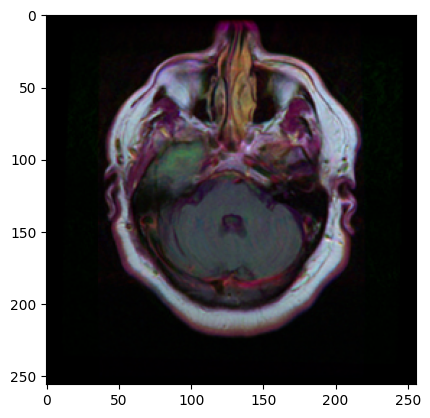

In [7]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)', marker_line_width = 7, opacity = 0.6)
fig.show()

brain_df.mask_path
brain_df.image_path
plt.imshow(cv2.imread(brain_df.mask_path[623]))
plt.imshow(cv2.imread(brain_df.image_path[623]))
cv2.imread(brain_df.mask_path[623]).max()
cv2.imread(brain_df.mask_path[623]).min()

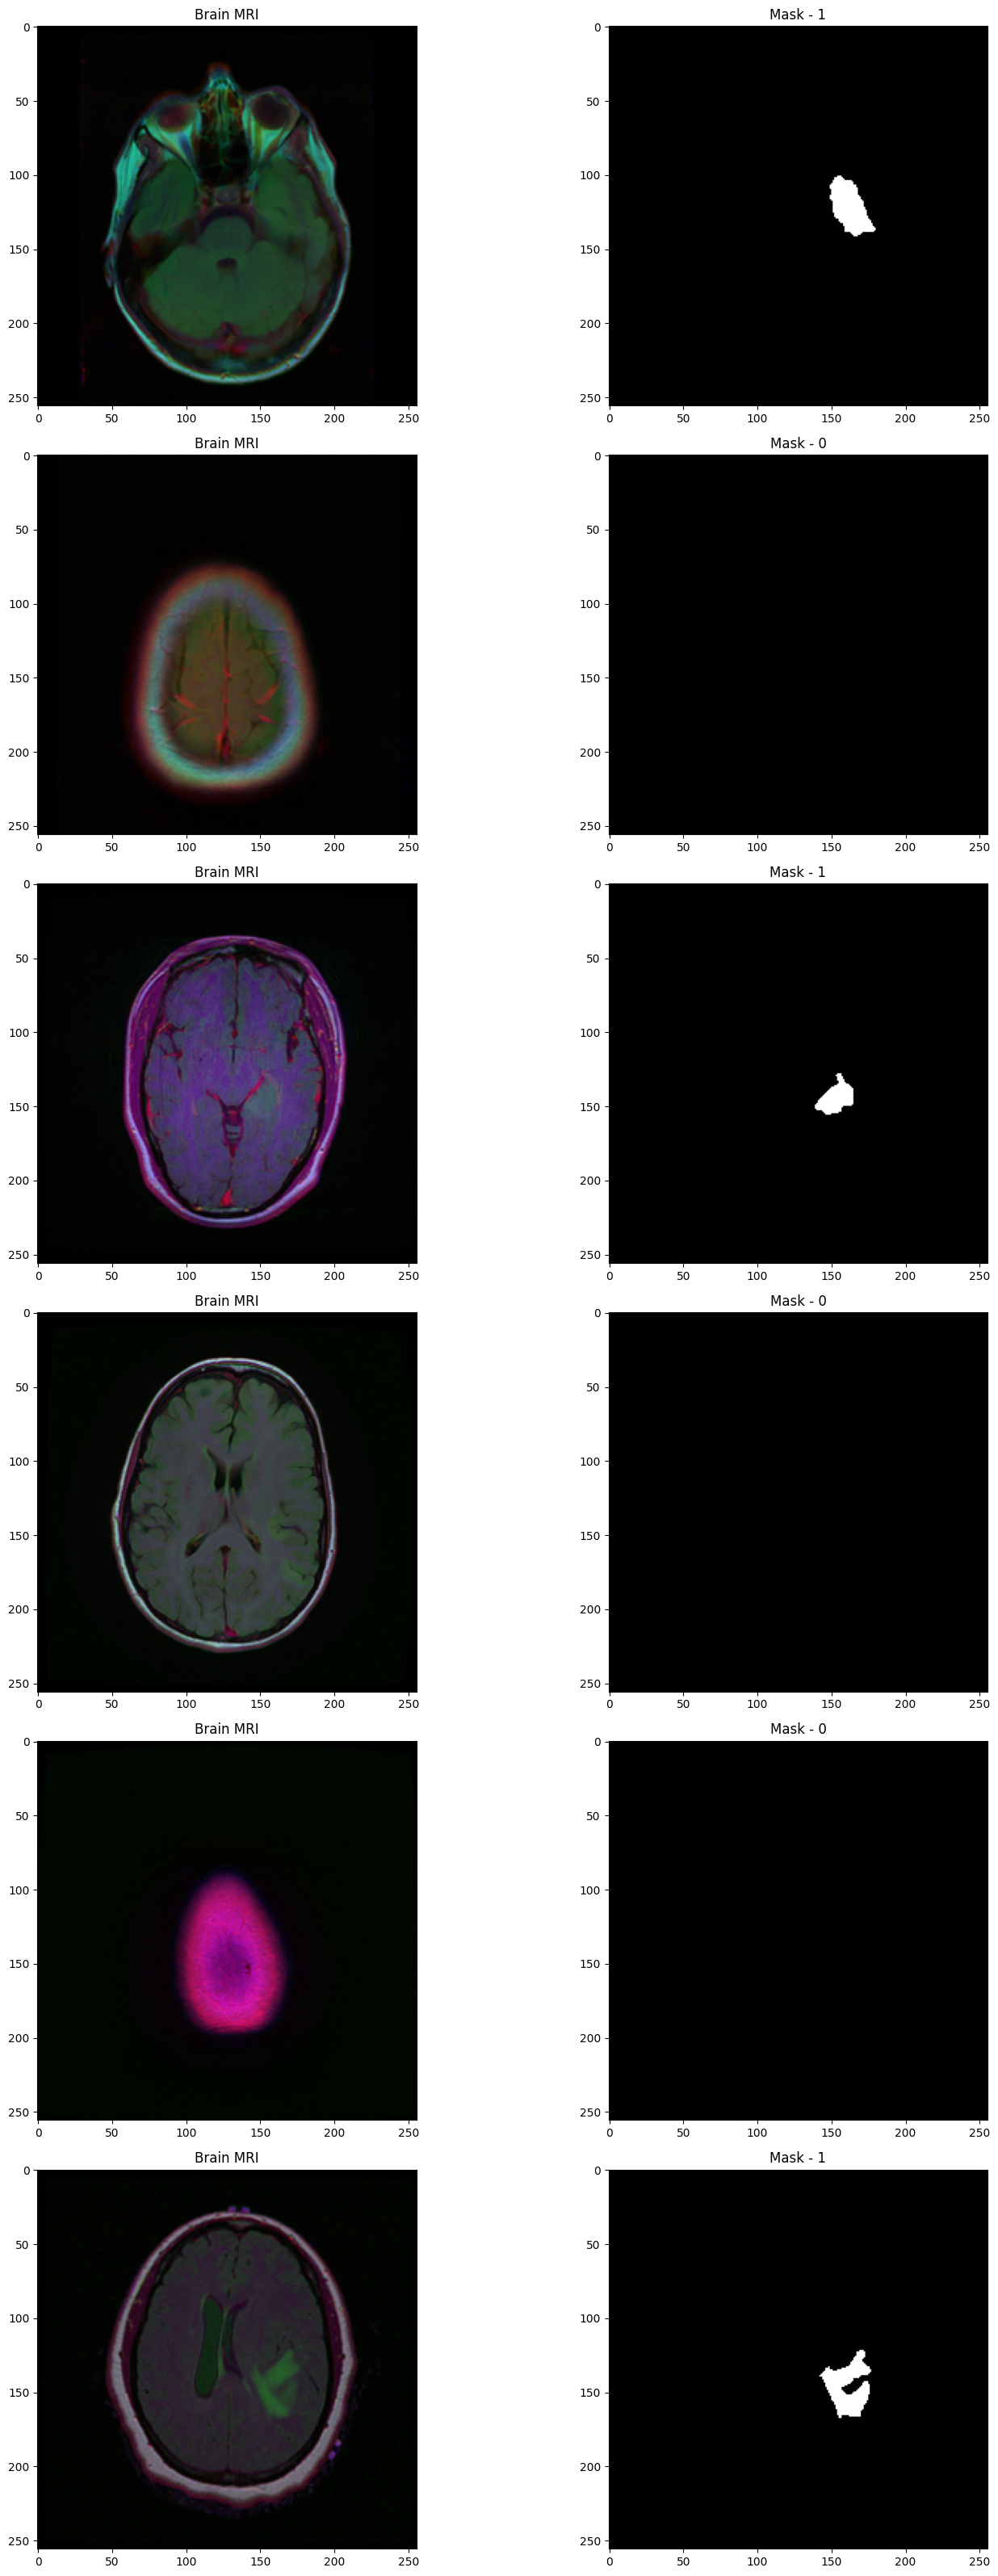

In [8]:
fig, axs = plt.subplots(6, 2, figsize=(16, 32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1

fig.tight_layout()


In [9]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)


In [11]:
!pip install keras_preprocessing


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [12]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset="training",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256, 256)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset="validation",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256, 256)
)

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    shuffle=False,
    class_mode='categorical',
    target_size=(256, 256)
)


Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [13]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
basemodel.summary()

for layer in basemodel.layers:
    layer.trainable = False

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

model = Model(inputs=basemodel.input, outputs=headmodel)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [14]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 16,
    epochs=1,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // 16,
    callbacks=[checkpointer, earlystopping]
)

177/177 [==============================] - ETA: 0s - loss: 0.7243 - accuracy: 0.6196 
Epoch 1: val_loss improved from inf to 0.63152, saving model to classifier-resnet-weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



177/177 [==============================] - 3306s 19s/step - loss: 0.7243 - accuracy: 0.6196 - val_loss: 0.6315 - val_accuracy: 0.6613


In [15]:
model_json = model.to_json()
with open("classifier-resnet-model.json", "w") as json_file:
    json_file.write(model_json)


In [16]:
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [17]:
test_predict = model.predict(test_generator, steps=test_generator.n // 16, verbose=1)
test_predict.shape
test_predict

predict = []
for i in test_predict:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)
predict

original = np.asarray(test['mask'])[:len(predict)]
len(original)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

36/36 [==============================] - 548s 16s/step


0.9704861111111112

In [22]:
def resblock(X, f):
    X_copy = X

    X = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    X_copy = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])
    return merge

input_shape = (256,256,3)
X_input = Input(input_shape)

conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size=(2,2))(conv1_in)

conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size=(2,2))(conv2_in)

conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size=(2,2))(conv3_in)

conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size=(2,2))(conv4_in)

conv5_in = resblock(pool_4, 256)

up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(up_4)

model_seg = Model(inputs=X_input, outputs=output)

from utilities import focal_tversky, tversky_loss, tversky

adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

# Debugging: Check input and output shapes
x_batch, y_batch = next(train_generator)
print(f"Train generator image batch shape: {x_batch.shape}")
print(f"Train generator mask batch shape: {y_batch.shape}")

try:
    history = model_seg.fit(train_generator, epochs=1, validation_data=valid_generator, callbacks=[checkpointer, earlystopping])
except Exception as e:
    print(f"Error during model fitting: {e}")

model_json = model_seg.to_json()
with open("ResUNet-model.json", "w") as json_file:
    json_file.write(model_json)


Train generator image batch shape: (16, 256, 256, 3)
Train generator mask batch shape: (16, 2)
Error during model fitting: Graph execution error:

Detected at node focal_tversky/mul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/p

In [23]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()

model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

In [24]:
from utilities import prediction

image_id, mask, has_mask = prediction(test, model, model_seg)

df_pred = pd.DataFrame({'image_path': image_id, 'predicted_mask': mask, 'has_mask': has_mask})
df_pred

df_pred = test.merge(df_pred, on='image_path')
df_pred.head()

1/1 [==============================] - 0s 20ms/step


image_path  \
0  TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_26...   
1  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38...   
2  TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_21...   
3  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_30...   
4  TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_20...   

                                           mask_path mask  \
0  TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_26...    1   
1  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38...    1   
2  TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_21...    1   
3  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_30...    0   
4  TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_20...    1   

                                      predicted_mask  has_mask  
0  [[[[9.2668324e-07], [5.5446176e-06], [1.013617...         1  
1  [[[[9.238322e-07], [3.5682685e-06], [7.4217473...         1  
2  [[[[1.15468e-06], [5.88236e-06], [1.18114895e-...         1  
3                                            No mask         0  
4  [[[[6.910949e-07], [2.412752e-06], [4.3387936e...         1

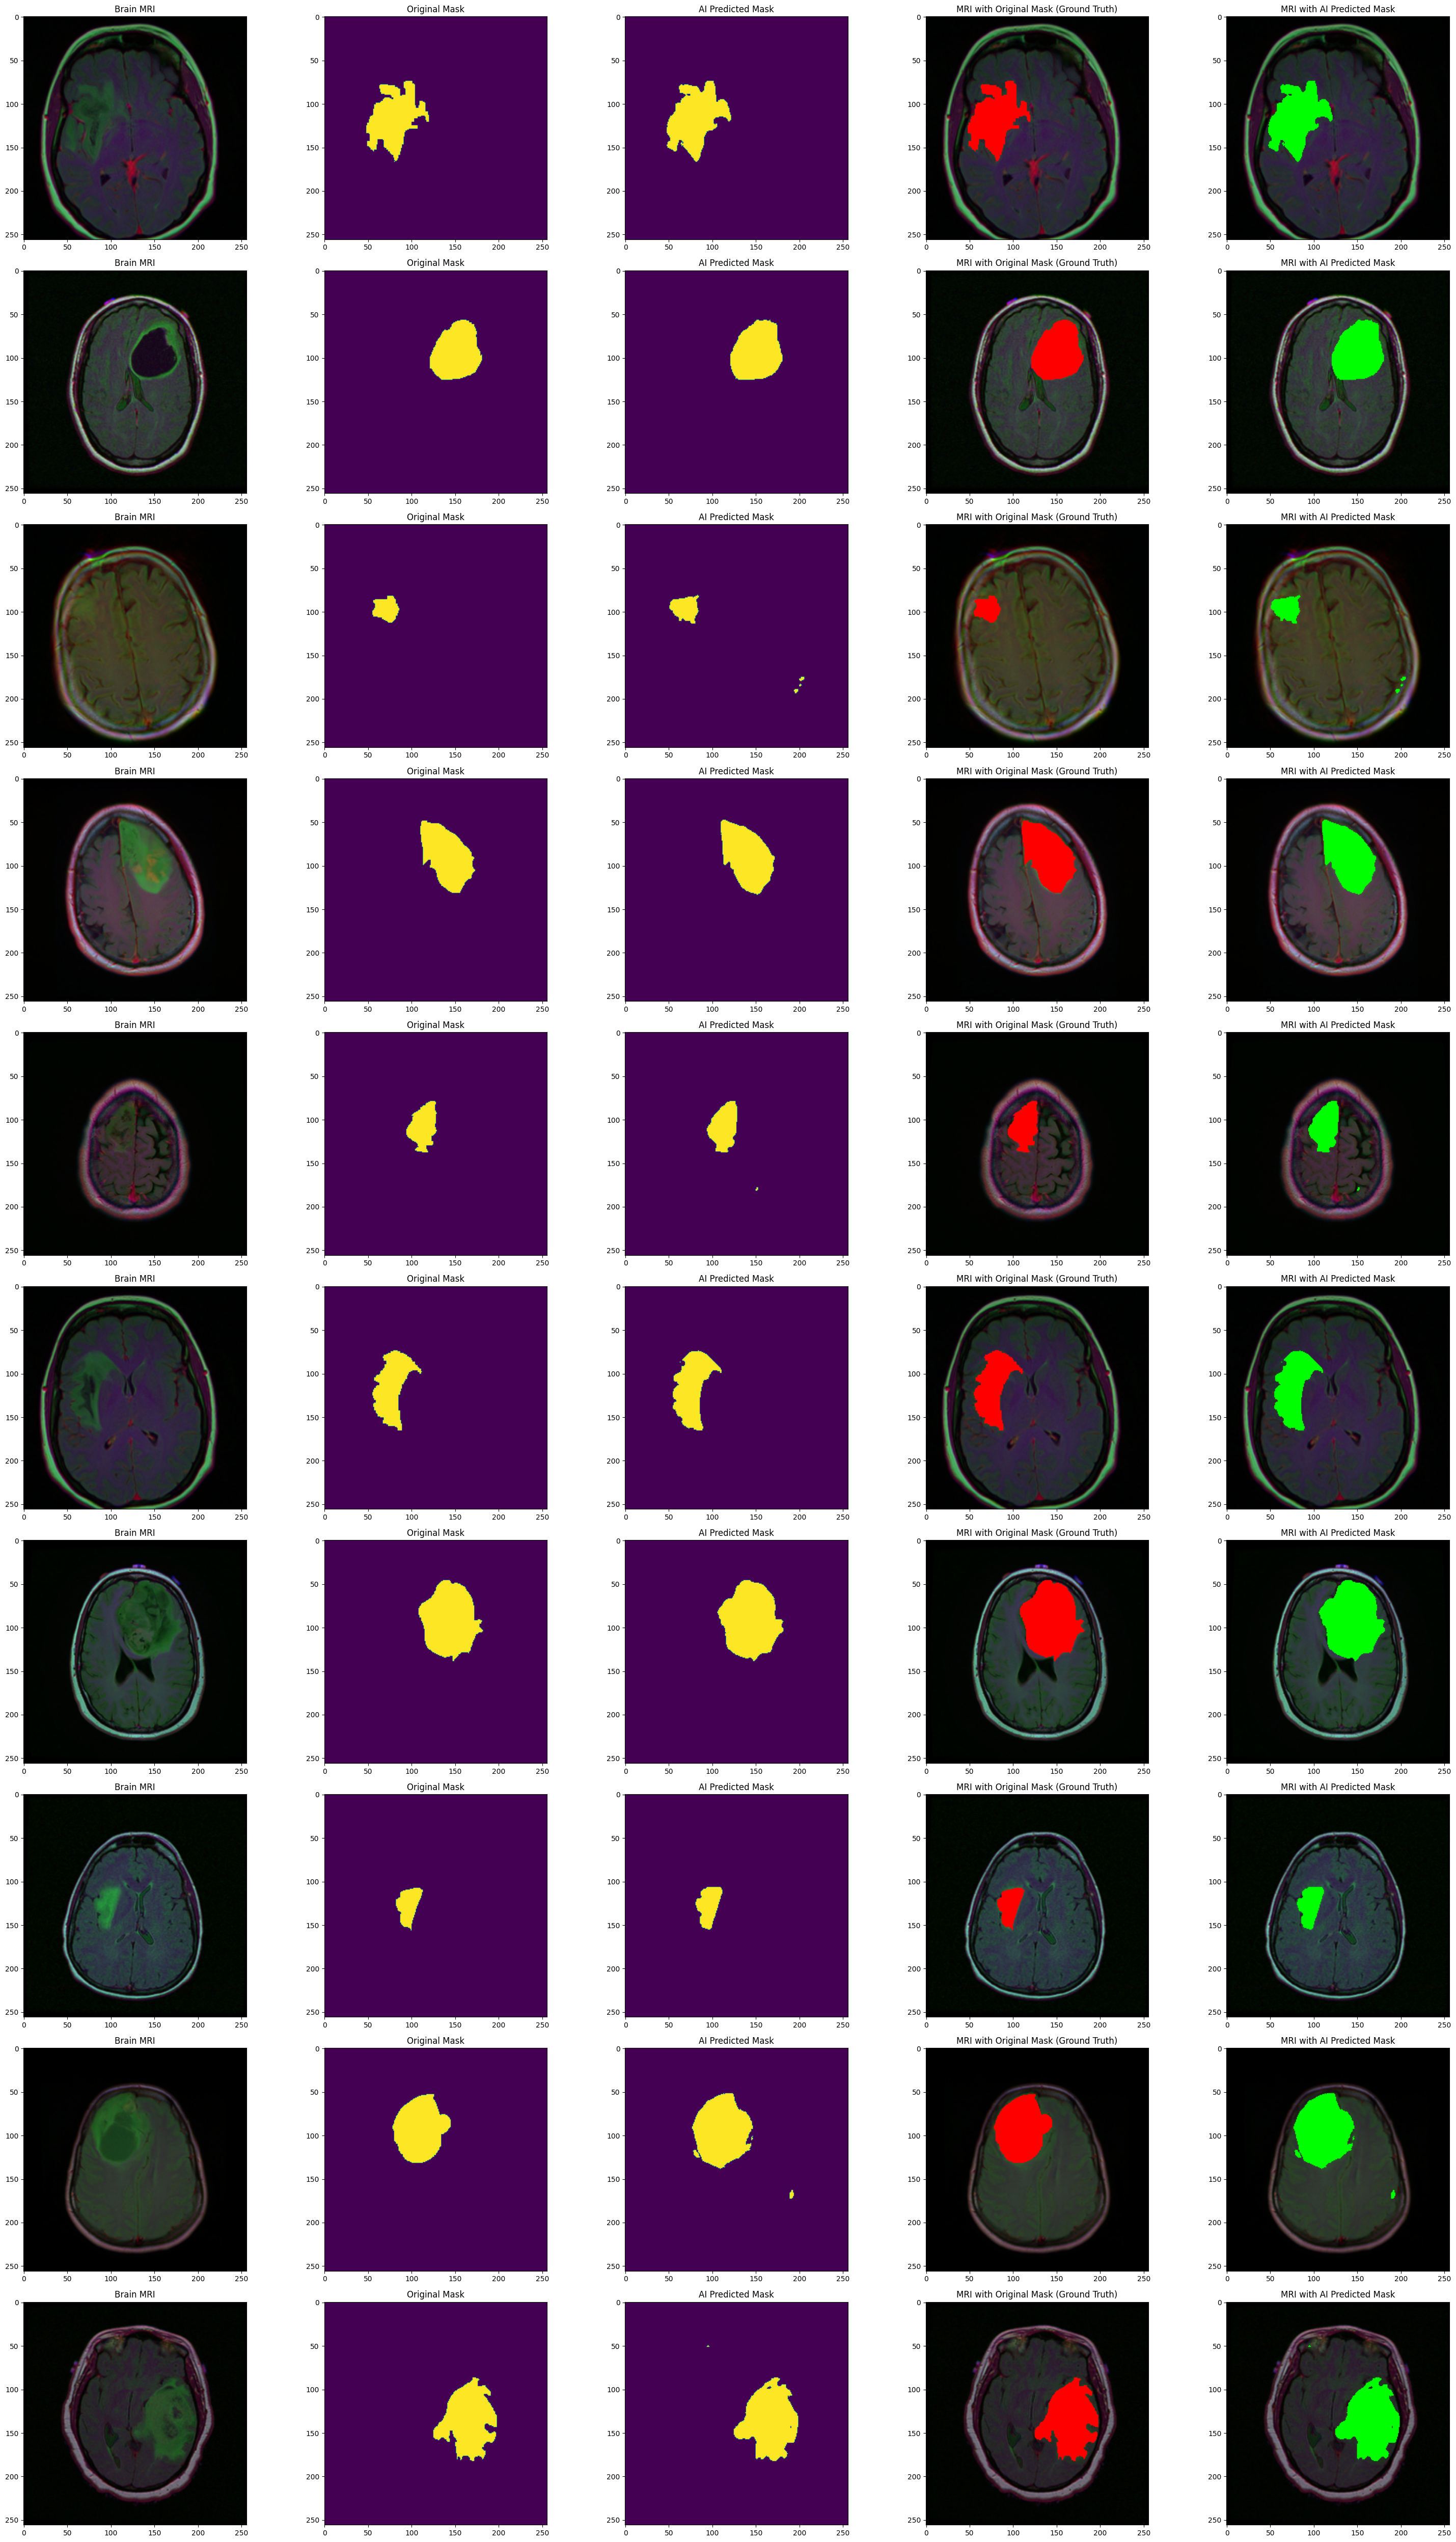

In [25]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1 and count < 10:
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].title.set_text("Original Mask")
        axs[count][1].imshow(mask)

        predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
        axs[count][2].title.set_text("AI Predicted Mask")
        axs[count][2].imshow(predicted_mask)

        img[mask == 255] = (255, 0, 0)
        axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
        axs[count][3].imshow(img)

        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[predicted_mask == 1] = (0, 255, 0)
        axs[count][4].title.set_text("MRI with AI Predicted Mask")
        axs[count][4].imshow(img_)
        count += 1

fig.tight_layout()